In [12]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imwrite

from fcn import VGGNet, FCNs
from dataset import SegmentationDataset, LabelToOnehot, imshow
from train import train_model, visualize_model

from util import list_files

plt.ion()

## Find normalization constants for data

Before loading images into the model to train, we wish to define a normalization procedure that forces the input data to have roughly zero mean and unit variance. This ensures that all possible inputs exist within the same input space and at the same scale, facilitating the network's learning capability. 

To find these normalization constants, we loop through the training data and compute the mean and std of each image. This can take a while, so feel free to skip to the next cell, which defines the means and stds using precomputed literals.

In [2]:
# find means and stds of dataset
imgs_list = list_files('stroma_epithelia/images')
np_means = np.zeros((len(imgs_list), 3))
np_stds = np.zeros_like(np_means)
for i, img_name in enumerate(imgs_list):
    img = imread(img_name)
    np_means[i] = np.mean(img, axis=(0, 1))
    np_stds[i] = np.std(img, axis=(0, 1))
    
channel_means = np.mean(np_means, axis=0)
channel_stds = np.std(np_stds, axis=0)

print('Means: {}'.format(channel_means))
print('Stds: {}'.format(channel_stds))

In [4]:
# use precomputed means and stds
channel_means = (164.60564156, 150.75147313, 178.36823845)
channel_stds = (9.46653235, 16.23701039, 9.48000306)

## Define dataloaders

The shapes of the input images are not consistent. As a quick fix, we crop the [224, 224] center square out of every image. These are then converted to PyTorch tensors and then normalized using the constants earlier.

The label masks must be cropped exactly as their corresponding images. In addition, they must be converted from labels into their one-hot encoding. This ensures that each label's representation in the network is statistically independent of the others. This would not be the case if we tried to represent each label as the values '0', '1', or '2', since '1' is halfway between '0' and '2' for instance.

Since we are dealing with histology images, normally we would want to make sure that every image is taken at or rescaled to be at a consistent magnification. However, we know these images are the same scale, so no resizing is performed. 

In [5]:
data_root = 'stroma_epithelia'
crop_size = 224
labels = (0, 1, 2)
dataset_phases = ['train']

n_labels = len(labels)

In [6]:
data_transforms = {
    'train': {
        'imgs': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(channel_means, channel_stds)
        ]),
        'masks': transforms.Compose([
            transforms.CenterCrop(crop_size),
            LabelToOnehot(labels),
            transforms.ToTensor()
        ])
    }
}

image_datasets = {x: SegmentationDataset(data_root, labels, 
                                         image_transforms=data_transforms[x]['imgs'],
                                         mask_transforms=data_transforms[x]['masks'])
                  for x in dataset_phases}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                             shuffle=True, num_workers=4)
               for x in dataset_phases}
dataset_sizes = {x: len(image_datasets[x]) for x in dataset_phases}

## Compare label and mask

Here we manually load one mask, count its labels, and display its one-hot encoded version. The encoded version should have the same structure as the label version, indicating that only individual pixel values have been changed.

Label 0: 120800 pixels
Label 1: 450220 pixels
Label 2: 174956 pixels


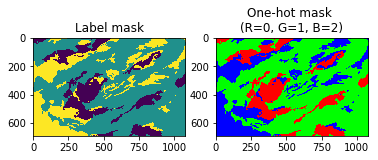

In [19]:
mask_name = 'stroma_epithelia/masks/0.1_110_2_1.png'
mask = imread(mask_name)
LO = LabelToOnehot(labels)
mask_oh = LO(mask)

plt.subplot(121)
plt.imshow(mask)
plt.title('Label mask')
plt.subplot(122)
plt.imshow(mask_oh)
plt.title('One-hot mask \n(R=0, G=1, B=2)')

labels, label_counts = np.unique(mask, return_counts=True)
for l, lc in zip(labels, label_counts):
    print('Label {}: {} pixels'.format(l, lc))

## Visualize images

Next we test the dataloader by loading batches of images and masks and displaying them in a grid.

Image shape: torch.Size([4, 3, 224, 224])
Masks shape: torch.Size([4, 3, 224, 224])


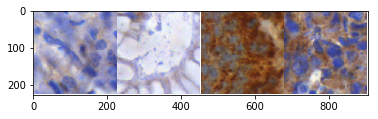

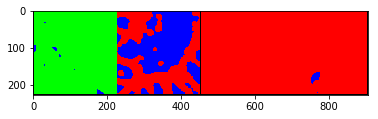

In [73]:
inputs, masks = next(iter(dataloaders['train']))
print('Image shape: {}'.format(inputs.shape))
print('Masks shape: {}'.format(masks.shape))

imshow(torchvision.utils.make_grid(inputs), means=channel_means, stds=channel_stds)
imshow(torchvision.utils.make_grid(masks), means=(0, 0, 0), stds=(255, 255, 255))

## Define model

Here we define the model and its training parameters. We employ the FCN variation of the pre-trained VGGNet, which should vastly improve training convergence and performance.

For a loss, we apply the binary cross entropy with logits loss, since we wish to measure the error of predictions between 0 and 1 across several logits.

In [74]:
learn_rate = 0.001
momentum = 0.9
step_size = 50
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_labels)

fcn_model = fcn_model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.SGD(fcn_model.parameters(), lr=learn_rate, momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

/home/masonmcgough/anaconda2/envs/PyTorchSIIM/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


## Train and evaluate

In [ ]:
fcn_model = train_model(fcn_model, dataloaders, criterion, optimizer_ft, scheduler, 
                        dataset_phases, dataset_sizes, device=device, num_epochs=25)
visualize_model(fcn_model, dataloaders, labels)